In [1]:
library(ComplexHeatmap)
library(circlize)

Loading required package: grid

ComplexHeatmap version 2.15.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements a

# set-up

Este notebook es el 5 del que salió el 5_1. Hay que actualizarlo si es necesario, pero crec que no

In [2]:
source('0_Rplots.R', echo=F, verbose = F)

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘ggrepel’ was built under R version 4.2.2”
Warning message:
“package ‘tidyr’ was built under R version 4.2.2”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Loading objects:
  GeneAnnotation
  meta.colors
  facets


[1] "none"             "Ultra peripheral" "Peripheral"       "Connector"       
[5] "Kinless"          "Provincial Hub"   "Connector Hub"    "Kinless Hub"

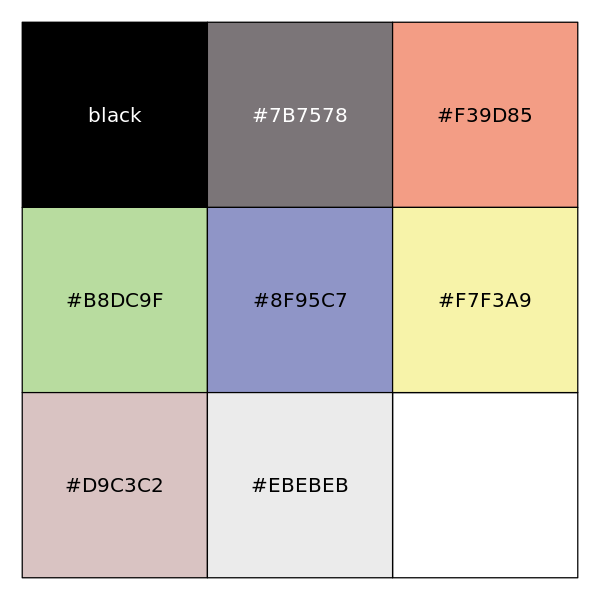

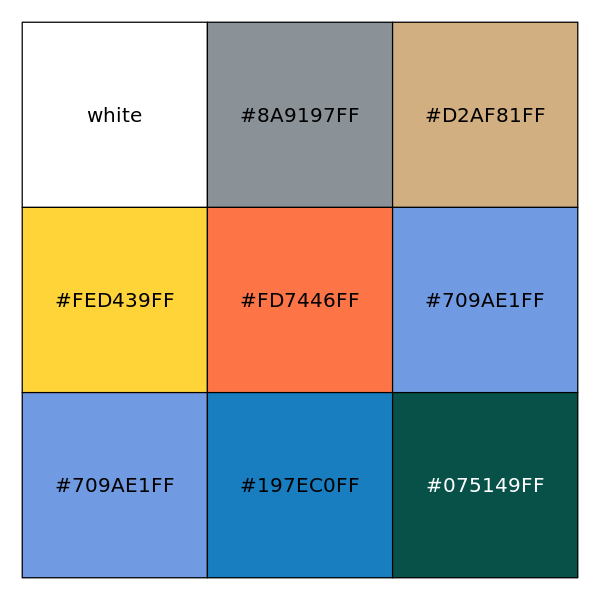

In [3]:
fig(5,5)
names(RoleColors)
scales::show_col(RoleColors)
RoleColorsNew <- setNames(
    c('white', ggsci::pal_simpsons()(16)[c(3,4,1,5,2,7,12)]),
    names(RoleColors))
RoleColorsNew['Peripheral Hub'] <- RoleColorsNew['Provincial Hub']
RoleColorsNew <- RoleColorsNew[
    c('none','Ultra peripheral','Peripheral','Connector','Kinless',
      'Peripheral Hub','Provincial Hub','Connector Hub','Kinless Hub')]
scales::show_col(RoleColorsNew)


## Functions

### `prepare plot parameters for each dataset`

In [4]:
prepare_df <- function(
    df,
    value,
    long.vars=NULL,
    long = F,
    gene = 'Gene',
    na.fill.value = NA,
    cluster_rows=F,
    cluster_columns=F,
    col=NULL,
    rect_gp=list(col = "#888888", lwd = .5),
    col_split=NULL,
    col_title_gp=NULL,
    col_names_gp=NULL,
    col_label = NULL,
    show_rows= T,
    col_names_side = 'top',
    border=TRUE,
    num3D = F,
    ...
){
    list(
        df=df,
        value=value,
        long.vars=long.vars,
        long=long,
        gene=gene,
        na.fill.value=na.fill.value,
        cluster_rows=cluster_rows,
        cluster_columns=cluster_columns,
        col=col,
        rect_gp=rect_gp,
        col_split=col_split,
        col_title_gp=col_title_gp,
        col_names_gp=col_names_gp,
        col_label=col_label,
        show_rows=show_rows,
        col_names_side=col_names_side,
        border=border,
        num3D=num3D
    ) -> hargs
    # print(hargs)
    return(hargs)
}

### `prepare plot matrix`

In [5]:
prepare_matrix <- function(dfs){
    ds <- dfs
    mat <- NULL

    for (i in 1:length(ds)){
        ds[[i]]$df <- as.data.frame(ds[[i]]$df)
        ds[[i]]$name <- names(ds)[i]
    }
    
    for (d in ds){

        d$meta.vars <- c(d$col_label, d$col_split)
        if (d$long){
            d$vars <- d$long.vars
            d$df <- d$df %>% arrange_at(d$vars) 
            
            if (!all(d$vars%in%colnames(d$df))){
                print(colnames(d$df))
                print(d$vars)
                stop()
            }
            d$df$cast_lab <- apply(d$df[,d$vars, drop=F], 2, as.character)%>%apply( MARGIN = 1, FUN=paste, collapse='+')
            d$df$cast_lab <- factor(d$df$cast_lab, unique(d$df$cast_lab))
            d$meta.vars <- c(d$meta.vars, d$vars, 'cast_lab')

            d$df %>% reshape2::dcast(paste(d$gene, 'cast_lab', sep='~'),
                                     value.var = d$value) -> m
            colnames(m) <- c('Gene',
                             paste(d$name, tail(colnames(m),-1), sep='_')) %>% make.names()
            ds[[d$name]]$meta <- unique(d$df[,d$meta.vars, drop=F]) %>%as.data.frame()
            
            rownames(ds[[d$name]]$meta) <- paste(d$name, ds[[d$name]]$meta$cast_lab, sep='_') %>% make.names()

        } else {
            m <- d$df[,c(d$gene, d$value),drop=F]
            d$meta.vars <- c(d$meta.vars, d$value)
            colnames(m) <- c('Gene',
                             paste(d$name, d$value, sep='_')) %>% make.names()

            ds[[d$name]]$meta <- data.frame(row.names = paste(d$name, d$value, sep='_') %>% make.names(),
                                            value=d$value)
            ds[[d$name]]$meta[, d$col_label] <- d$col_label

        }

        ds[[d$name]]$matnames <- tail(colnames(m),-1)
        ds[[d$name]]$meta <- ds[[d$name]]$meta[ds[[d$name]]$matnames,,drop=F]


        mat <- if(is.null(mat)){m}else{merge(mat, m, by='Gene', all=T)}
    }
    mat <- mat[!apply(is.na(mat), 1, all),] 
    rownames(mat) <- mat$Gene
    return(list(ds=ds, mat=mat))
}

filter_geneset <- function(mat, geneset){
    
    if (!is.null(geneset)){
        pmat <- mat
        geneset.mask <- geneset %in% rownames(pmat)
        if (sum(!geneset.mask)>0){message(glue::glue('Ignoring {sum(!geneset.mask)} genes [{paste(head(geneset[!geneset.mask]), collapse=", ")}]'))}
        geneset <- geneset[geneset.mask]
        pmat <- pmat[geneset,, drop=F]
        return(pmat)
    } else {
        return(mat)
    }
}


### `ComplexHeatmap helpers`

In [6]:
as.gpar <- function(l, def=gpar()){
    if (is.null(l)){
        l <- def
   }else{
        class(l) <- 'gpar'
    }
    return(l)
}

ht_opt$TITLE_PADDING = unit(c(4, 4), "points")

do_heatmaps <- function(ds, mat){

    
    lapply(ds, function(d){
        
        pmat <- mat[,d$matnames, drop=F] %>%mutate_all(function(x){ifelse(is.na(x), d$na.fill.value, x)}) %>% as.matrix
        col_split <- if(!is.null(d$col_split)){d$meta[,d$col_split]}else{NULL}
        col_labels <- as.character(if(!is.null(d$col_label)){d$meta[,d$col_label,drop=T]}else{colnames(pmat)})        
        
        htmp.args <- list(
            matrix = pmat, 
            col=d$col,
            border = d$border,
            show_row_names = d$show_rows,
            row_names_side = 'left',
            column_names_side = d$col_names_side,
            cluster_rows = d$cluster_rows, cluster_columns = d$cluster_columns,
            column_split=col_split,
            column_labels=col_labels,
            name = d$name,
            column_names_gp = as.gpar(d$col_names_gp),
            column_title_gp = as.gpar(d$col_title_gp),
            rect_gp = as.gpar(d$rect_gp) # this must be excluded in 3D
        )
        num3D.args <- head(names(htmp.args),-1)
        
        if (d$num3D){
            if (nrow(pmat)>50){warning('Doing 3D plots for big matrices is discouraged.')}
            h <- rlang::exec(.fn = Heatmap3D, !!!htmp.args[num3D.args])
        } else {
            h <- rlang::exec(.fn = Heatmap, !!!htmp.args)
        }
        h
    }) -> htmps
    return(htmps)
}

combine_heatmaps <- function(htmps){
    htmp <- htmps[[1]]
    for (i in 2:length(htmps)){
        htmp <- htmp + htmps[[i]]
    }
    return(htmp)
}


### `saving plot`

In [7]:
# NG  H
#########
# 17  5
# 141 22
# 25 6
# 36 7
# 56 9.5
h.lm <- lm(formula = 'y~x', data.frame(x=c(17,141,25,36,56), y= c(5,22,6,7,9.5)))$coefficients

# NCT  W
#########
# 8  20
w.lm <- lm(formula = 'y~x', data.frame(x=c(8,5), y= c(20,15)))$coefficients


get_dims <- function(htmp, h.max=25, w.max=21){
    base.dim <- dim(htmp@ht_list$`No. cells ratio\nfinal/initial`)
    # print(base.dim)
    h <- min(h.lm['x']*base.dim[1]+h.lm[1], h.max)
    w <- min(w.lm['x']*base.dim[2]+w.lm[1], w.max)
    return(c( w=w, h=h))
}

### `matrix sorting`

#### `general`

In [8]:
sort.vector.by.vector <- function(x, ref.vec, do.character=T, na.last=T){
    
    if (do.character){
        ref.vec <- as.character(ref.vec)
        x <- as.character(x)
    }
    s <- c(intersect(ref.vec, x))
    if (na.last){
        s <- c(s, c(x[!x%in%ref.vec]))
    }

    return(s)  
}

sort.matrix.by.vector <- function(x, ref.vec, cols=F, do.character=T, na.last=T){
    if (cols){
        return(x[, sort.vector.by.vector(colnames(x), ref.vec= ref.vec, do.character=do.character, na.last=na.last)]%>%t())
    }else{
        return(x[sort.vector.by.vector(rownames(x), ref.vec= ref.vec, do.character=do.character, na.last=na.last),])
    }
}



sort.matrix.diagonal <- function(x, cols=F, direction=1){
    if (cols){
        return(sort.matrix.diagonal(t(x), cols=F, direction=direction)%>%t())
    } else {
        reshape2::melt(as.matrix(x)*direction) %>% rename(row=Var1, col=Var2)%>% 
            mutate(col=factor(as.character(col), colnames(x))) %>%
            arrange(value) %>% group_by(row) %>% slice_head(n=1) %>% # select max col per row
            ungroup() %>% arrange(col, value) %>% # sort columns and genes in max
            select(row) %>% unlist(recursive=T) %>% as.character() -> sorted.rows        
        return(x[sorted.rows,])
    }
}

sort.matrix.grouped.diagonal <- function(x, groups, cols=F, direction=1){
    if (cols){
        return(sort.matrix.grouped.diagonal(t(x), groups, cols=F, direction=direction)%>%t())
    } else {
        xplit <- split(x, groups)
        xplit <- lapply(xplit, sort.matrix.diagonal, direction=direction, cols=F) %>% setNames(nm=names(xplit))
        xplit.avg <- lapply(xplit, colMeans) %>% do.call(what='rbind') %>% as.data.frame()
        sorted.groups <- sort.matrix.diagonal(xplit.avg, direction=direction, cols=F) %>% rownames()
        sorted.groups <- plyr::mapvalues(x=sorted.groups, from = rownames(xplit.avg), to=names(xplit))
        sorted.rows <- xplit[sorted.groups] %>% lapply(rownames) %>% unlist()
        return(x[sorted.rows,])       
        
    }
}



sort.cluster.matrix <- function(x, cols=F, direction=1, centers=5, iter.max = 100, ...){
    if (cols){
        return(sort.cluster.matrix(t(x), cols=F, direction=direction, centers=centers, iter.max = iter.max, ...) %>% t())
    } else {
        if (is.null(centers)){
            centers <- sqrt(nrow(x))
        }

        km <- amap::Kmeans(x, centers=centers, iter.max = iter.max, ...)
        row_clusters <- plyr::mapvalues(x=rownames(x), from=names(km$cluster), to=km$cluster)

        return(sort.matrix.grouped.diagonal(x, groups=row_clusters, cols=F, direction=direction))
    }
}

#### `for ComplexHeatmap`

In [9]:
sorting.funs <- list(
    'sort by Peak phase'= function(x){
        sort.matrix.by.vector(x, ref.vec=genes.phase_order, cols=F)
    },
    
    
    'sort by Transitions' = function(x){
        use.cols <- grep('transition', colnames(x), value=T, fixed=T)
        
        gsub(use.cols, pattern='X..cells.transitioned_', replacement='', fixed=T)%>% 
        gsub(pattern='.KO', replacement='', fixed=T) -> cols
        
        use.cols <- use.cols[sapply(cols, function(x){
            substr(x, start = 1, stop = floor(nchar(x)/2)) == substr(x, start = ceiling(nchar(x)/2)+1, stop=nchar(x))})]

        sorted.genes <- rownames(sort.matrix.diagonal(x[,use.cols, drop=F], cols=F, direction=-1))
        return(x[sorted.genes,])},
    
    
    'cluster by Transitions' = function(x){
        use.cols <- grep('transition', colnames(x), value=T, fixed=T)
        
        gsub(use.cols, pattern='X..cells.transitioned_', replacement='', fixed=T)%>% 
        gsub(pattern='.KO', replacement='', fixed=T) -> cols
        
        use.cols <- use.cols[sapply(cols, function(x){
            substr(x, start = 1, stop = floor(nchar(x)/2)) == substr(x, start = ceiling(nchar(x)/2)+1, stop=nchar(x))})]

        sorted.genes <- rownames(sort.cluster.matrix(x[,use.cols, drop=F], cols=F, direction=-1))
        return(x[sorted.genes,])},
    
    
    'sort by Ratio' = function(x){
        use.cols <- grep('ratio', colnames(x), value=T, fixed=T)
        sorted.genes <- rownames(sort.matrix.diagonal(x[,use.cols, drop=F], cols=F, direction=-1))
        return(x[sorted.genes,])},
    
    
    'cluster by Ratio' = function(x){
        use.cols <- grep('ratio', colnames(x), value=T, fixed=T)
        sorted.genes <- rownames(sort.cluster.matrix(x[,use.cols, drop=F], cols=F, direction=-1))
        return(x[sorted.genes,])}
)

# X <- dsmats$Gliogenesis$mat[,c(dsmats$Gliogenesis$ds[['No. cells ratio\nfinal/initial\nscaled']]$matnames,
#                                dsmats$Gliogenesis$ds[['% cells\ntransitioned']]$matnames)]

## Data for all versions

### Gene sets

In [10]:
geneset_list.general <- list(
    `All TFs tested` = unique(Perturbations$Gene),
    `Core TFs (Disease or Phase)` = regulon_cores,
    `Regulons` = regulon_genes,
    `Disease-linked` = disease_genes,
    `Phase core TF or Disease-linked` = union(disease_genes, regulon_cores)
) 
geneset_list.general <- geneset_list.general[names(sort(sapply(geneset_list.general, length)))]

### Disease and phase info

In [11]:
dis.df <- get.conf.dis.df(unique(Perturbations$Gene))
peak.df <- data.frame(
    Gene=names(peak.per.gene),
    Core=ifelse(names(peak.per.gene)%in%peakcores, 'Core TF', 'Not core TF'),
    PeakSample=peak.per.gene)

peak.df %>% 
    mutate(ps=factor(PeakSample, names(meta.colors$PeakSample))) %>% 
    arrange(ps) %>% select(Gene)%>% 
    unlist(recursive = T)%>% unname -> genes.phase_order

### Prepare data

In [12]:
list(
    `Peak phase` = prepare_df(long = F,
                              df = peak.df[, c('Gene', 'PeakSample'), drop=F],
                              value = 'PeakSample',
                              col=meta.colors$PeakSample,
                              rect_gp=list(col = "white", lwd = 1),
                              col_label = 'Peak phase'),
    
    `Phase regulon` = prepare_df(df = peak.df[, c('Gene', 'Core'), drop=F],
                                 value = 'Core',
                                 na.fill.value = 'Not core TF',
                                 col=c('Core TF'='#000000', 'Not core TF'='#FFFFFF'),
                                 col_label = 'Phase regulon'),
    
    `Disease association` = prepare_df(long = T,
                                       df = dis.df,
                                       long.vars = 'Disease',
                                       value = 'Value',
                                       na.fill.value = 'None',
                                       col=dis.conf.cols,
                                       col_label = 'Disease')
) -> dfs.general

dfs.order <- c(
    'Peak phase',
    'Phase regulon',
    'No. cells ratio\nfinal/initial\nscaled',
    '% cells\ntransitioned',
    'Role in GRN',
    'Disease association'
)

# Produce `[for each sample]`

In [13]:
out.folder <- glue::glue('../results/Plots/Perturbation_heatmaps.{Sys.Date()}/')

In [14]:
plot.samples <- unique(Perturbations$Sample)
# plot.samples <- SampleInclude
plot.samples <- plot.samples[plot.samples!='RGCmaturation']
plot.samples

[1] "Gliogenesis" "NeuralPCW16" "NeuralPCW20" "NeuralPCW21" "NeuralPCW24"

## Parametrize datasets (grouping variables, colors, labels...) 

In [15]:
dsmats <- list()
for (this.sample in plot.samples){
    message(this.sample)
    pert.df <- subset(Perturbations, (Pert == 'KO')&(Sample == this.sample))
    lapply(split(pert.df, apply(pert.df[,c('Pert', 'Sample', 'cell.type')], 1, paste, collapse='')), function(dct){
        positives <- subset(dct, ratio>=1)    
        negatives <- subset(dct, ratio<1)  
        positives$ratio.scaled <- scales::rescale(x = positives$ratio, from=c(1, max(positives$ratio, na.rm = T)), to=c(0.5,1))
        negatives$ratio.scaled <- scales::rescale(x = negatives$ratio, from=c(min(negatives$ratio, na.rm=T) ,1), to=c(0,0.5))
        rbind(positives, negatives)
    })%>% do.call(what='rbind') %>% as.data.frame() -> pert.df
    trans.df <- subset(PerturbationsCT, (Pert == 'KO')&(Sample == this.sample))
    network.df <- subset(NetworkScores, Sample == this.sample)

    # fig(20,5)
    # p <- ggplot(pert.df, aes(x=ratio, y=ratio.scaled))+geom_point() + facet_wrap(~cell.type, nrow=1) + geom_hline(yintercept = 0.5) + geom_vline(xintercept = 1)
    # plot(p)
    same.trans.col <- trans.df%>%select(CTO,CTF)%>%unique()%>% arrange_all() %>%
        apply(1, function(x){if(x[1]==x[2]){'red'}else{'black'}})

    this.dfs <- list(
        
        `No. cells ratio\nfinal/initial\nscaled` = prepare_df(
            df = pert.df, 
            long = T, long.vars = c('cell.type','Pert'),
            value = 'ratio.scaled',na.fill.value = 0,
            col = colorRamp2(seq(from = 0, to=1, length.out = 3), c("darkblue", "#bbddcc", "#FFEE00")),
            col_label = 'cell.type'),  

        `% cells\ntransitioned` = prepare_df(
            df = trans.df,
            long = T, long.vars = c('CTO','CTF','Pert'),
            value = 'trans.pct', na.fill.value = 0,
            col = colorRamp2(seq(from = 0, to=100, length.out = 11), viridis::magma(11, direction = -1)),
            col_label = 'CTF', col_split = 'CTO',
            col_title_gp = list(fill = '#EEEEEE'), col_names_gp = list(col = same.trans.col),
            num3D=F),
    
        `Role in GRN` = prepare_df(
            df = network.df,
            long = T, long.vars = c('cell.type'),
            value = 'Role name', na.fill.value = 'none',
            col=RoleColorsNew, col_label = 'cell.type'))    
    
    
    
    
    
    
    dfs <- c(dfs.general, this.dfs)[dfs.order]
    dsmats[[this.sample]] <- prepare_matrix(dfs)
}

Gliogenesis

NeuralPCW16

NeuralPCW20

NeuralPCW21

NeuralPCW24



In [16]:
### subset to genes perturbed:
for (this.sample in names(dsmats)){
    dsmats[[this.sample]]$mat <- dsmats[[this.sample]]$mat[
        rownames(dsmats[[this.sample]]$mat) %in% unique(subset(Perturbations, Sample==this.sample)$Gene),]
}

## All versions `[for each sorting method]` `[for each geneset]`

In [17]:
for (sort.by in names(sorting.funs)){
    
    sort.fn <- sorting.funs[[sort.by]]
    
    for (gset.name in names(geneset_list.general)){

        geneset <- geneset_list.general[[gset.name]]
        
        htmps.samples <- list()
        p.dims <- c(0,0)
        
        for (this.sample in names(dsmats)){
            this.ds <- dsmats[[this.sample]]$ds
            this.mat <- sort.fn(filter_geneset(dsmats[[this.sample]]$mat, geneset = geneset))
            
            htmps <- do_heatmaps(this.ds, this.mat)
            htmp <- combine_heatmaps(htmps)
            htmps.samples[[this.sample]] <- htmp
            
            this.dims <- get_dims(htmp)
            p.dims[1] <- max(p.dims[1], this.dims[1])
            p.dims[2] <- max(p.dims[2], this.dims[2])     
        }
        
        plot.fname <- glue::glue('{out.folder}{sort.by}/{make.names(gset.name)}.pdf')
        dir.create(dirname(plot.fname), recursive = T)
        
        cairo_pdf(plot.fname, onefile = T, width = p.dims[1], height = p.dims[2])
        for (this.sample in names(htmps.samples)){
            grid.newpage()
            draw(htmps.samples[[this.sample]], 
                 column_title=glue::glue('{this.sample} ({sort.by})\nKnock-out simulation results of {gset.name}'))
        }
        dev.off()
    }
}

Ignoring 68 genes [ARNT2, CHD1, EP300, GLIS1, GTF2I, KLF16]

Ignoring 74 genes [ARNT2, CHD1, EGR3, EP300, GLIS1, GTF2I]

Ignoring 71 genes [ARNT2, CHD1, EP300, GLIS1, GTF2I, KLF16]

Ignoring 72 genes [ARNT2, CHD1, EGR3, EP300, GLIS1, GTF2I]

Ignoring 69 genes [ARNT2, CHD1, EP300, GLIS1, GTF2I, KLF16]

Warning message in dir.create(dirname(plot.fname), recursive = T):
“'../results/Plots/Perturbation_heatmaps.2024-03-18/sort by Peak phase' already exists”
Ignoring 208 genes [ERF, GLI3, SOX2, HMGN3, POU2F3, SOX13]

Ignoring 226 genes [SOX8, MYBL2, MAFF, GFI1B, POU3F1, ELK3]

Ignoring 202 genes [SOX8, MYBL2, SOX17, GFI1B, ELK3, SIN3A]

Ignoring 216 genes [SOX8, SOX17, GFI1B, ELK3, SIN3A, NKX2-2]

Ignoring 193 genes [MYBL2, SOX17, GFI1B, ELK3, SIN3A, NKX2-2]

Warning message in dir.create(dirname(plot.fname), recursive = T):
“'../results/Plots/Perturbation_heatmaps.2024-03-18/sort by Peak phase' already exists”
Ignoring 2218 genes [TSEN34, RAB18, CASK, CENPE, KIF14, QARS]

Ignoring 2214 gen